# Notebook 2: Advanced Quantum Tomography
## Deep Learning (DNN) & Variational Quantum Circuits (VQC) vs. Classical SVR

## 1. Scientific Context & Exploration Goals
In the previous notebook, we established a robust baseline using **Support Vector Regression (SVR)**, a classical kernel-based method. While effective, SVR relies on fixed kernels (RBF, Polynomial) which may not perfectly capture the complex geometry of quantum states under decoherence.

In this second exploratory phase, we move towards **Advanced Architectures**. Our goal is to determine if models with higher representational capacity (Deep Learning) or native quantum priors (VQC) can surpass the classical baseline, particularly in the regime of **impure states (decoherence)** and **limited data**.

We investigate two challengers:
1.  **Deep Neural Networks (DNN):** Using the universal approximation theorem to model the mapping from measurements to density matrices with high non-linearity.
2.  **Variational Quantum Circuits (VQC):** A "Quantum Machine Learning" approach. We hypothesize that a quantum circuit possesses a natural *inductive bias* for quantum data, potentially requiring fewer parameters to represent the Hilbert space than a classical network.

## 2. A Paradigm Shift: "Physics-Informed" Training
Unlike standard regression which minimizes the Euclidean distance (MSE), we introduce a **Custom Loss Function** grounded in Quantum Information Theory.

### The "Fidelity-Based" Backpropagation
Standard ML optimizes geometry. We want to optimize **physics**.
Instead of blindingly minimizing $MSE = ||\vec{r}_{pred} - \vec{r}_{real}||^2$, we configure our Neural Networks (both Classical and Quantum) to directly maximize the **Quantum Fidelity** ($F$).

During the **Backpropagation** pass, the gradient of the Fidelity is computed with respect to the model weights. This forces the optimizer to prioritize directions that increase the physical overlap between the predicted and true states.

**The Mathematical Loss Function:**
For a single qubit state defined by a Bloch vector $\vec{r}$, the loss $\mathcal{L}$ to minimize is:

$$\mathcal{L} = 1 - F(\rho_{pred}, \rho_{real})$$

Where the Fidelity $F$ for single-qubit Bloch vectors is given analytically by:
$$F(\vec{r}_{p}, \vec{r}_{t}) = \frac{1}{2} \left( 1 + \vec{r}_{p} \cdot \vec{r}_{t} + \sqrt{(1 - ||\vec{r}_{p}||^2)(1 - ||\vec{r}_{t}||^2)} \right)$$

* **Interpretation:** The term $\vec{r}_{p} \cdot \vec{r}_{t}$ aligns the vectors directionally. The term under the square root penalizes errors in **purity** (vector length). This allows the DNN to specifically "learn" decoherence.

## 3. Architecture Overview

### A. Deep Neural Network (DNN - PyTorch)
* **Structure:** A Multi-Layer Perceptron (MLP) with fully connected layers and non-linear activation functions (ReLU).
* **Why:** To test if a "Universal Approximator" can learn the noise models better than fixed kernels.

### B. Variational Quantum Circuit (VQC - PennyLane)
* **Concept:** We use a parameterized quantum circuit as the model.
* **Mechanism:**
    1.  **Encoding:** Classical inputs ($X, Y, Z$) are embedded into a quantum state via rotation gates.
    2.  **Processing:** A sequence of trainable gates (Ansatz) manipulates the state.
    3.  **Measurement:** We measure the expectation values of Pauli operators to obtain the output vector.
* **Hypothesis:** "Quantum for Quantum". A quantum circuit naturally evolves on the Bloch sphere (or inside it for mixed states via subsystems), which might offer better generalization with fewer parameters.

## 4. Implementation: High-Performance Computing (GPU)
With SVC, we had quite some long training time. So in order to handle the computational load of training deep networks and simulating quantum circuits, we leverage **GPU Acceleration**:
* **PyTorch (CUDA/MPS):** For tensor operations and automatic differentiation of the DNN.
* **PennyLane Lightning GPU:** Using high-performance state-vector simulators (like `lightning.gpu` or `lightning.qubit`) to accelerate the VQC simulation and gradient calculation (adjoint differentiation).

We also do this as a way to learn modern high-performance ML pipelines.

## 5. Input/Output Interfaces
To ensure a rigorous comparison with the SVR baseline from Notebook 1, the I/O structure remains identical:

* **Input $\mathbf{X}$:** Noisy measurement expectations $[ \langle X \rangle_{noise}, \langle Y \rangle_{noise}, \langle Z \rangle_{noise} ]$.
* **Output $\mathbf{y}$:** Predicted Bloch vector components $[\hat{x}, \hat{y}, \hat{z}]$.

*Note: The predicted vector is implicitly constrained to valid physical states (norm $\le$ 1) either via activation functions (Tanh) or penalty terms in the loss.*

#  Pourquoi le VQC ? (L'Hypothèse de l'Inductive Bias)

Dans cette section, nous introduisons un **Circuit Quantique Variationnel (VQC)** pour challenger le DNN classique. L'approche est fondamentalement différente de l'apprentissage profond standard.

### 1. Le DNN : La "Force Brute"
Le Deep Neural Network travaille dans un espace vectoriel réel classique ($\mathbb{R}^N$). Il est "naïf" vis-à-vis de la physique : il doit **apprendre** que la sortie doit être une matrice densité valide (positive, trace 1, norme $\le 1$). Il y parvient grâce à une immense capacité de paramètres et de non-linéarités (ReLU, Tanh), mais il approxime la physique de l'extérieur.

### 2. Le VQC : "Apprendre dans l'Espace de Hilbert"
Le VQC est un modèle **natif**.
* **Encodage Direct :** Nos données d'entrée (mesures bruitées) sont directement transformées en états quantiques (rotations de qubits).
* **Contraintes Physiques Garanties :** Le traitement se fait par des portes unitaires ($U^\dagger U = I$). Par construction, l'état évolue sur la sphère de Bloch (ou l'hypersphère de l'espace de Hilbert). Il est impossible pour le VQC de prédire un état physiquement "impossible" (norme > 1).

### L'Hypothèse Scientifique
Nous testons ici l'**Inductive Bias** (Biais Inductif) :
> *Un modèle dont la structure mathématique interne ressemble au système étudié (mécanique quantique) devrait apprendre plus efficacement (moins de paramètres, moins de données) qu'un modèle générique, même s'il est plus difficile à entraîner.*

In [14]:
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pennylane as qml

# Import du générateur de dataset (gestion d'erreur si le chemin varie)
try:
    from saint_dtSet import generate_qubit_tomography_dataset_base
except ImportError:
    # Fallback ou ajuster selon ton arborescence
    from dataset_build.saint_dtSet import generate_qubit_tomography_dataset_base

# ==========================================
# 1. SETUP GPU & DEVICE
# ==========================================
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps") # Mac M1/M2/M3
    else:
        return torch.device("cpu")

DEVICE = get_device()
torch.manual_seed(42)
np.random.seed(42)
print(f"✅ Computation Device: {DEVICE}")

# ------------------------------------------------------------------
# 2. OUTILS MATHÉMATIQUES & DATALOADERS (Définis AVANT usage)
# ------------------------------------------------------------------
def fidelity_from_bloch(pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    """Calcul de la fidélité entre vecteurs de Bloch prédits et réels."""
    dot = (pred * target).sum(dim=-1)
    norm_pred = (pred ** 2).sum(dim=-1)
    norm_target = (target ** 2).sum(dim=-1)
    # Clamp pour éviter les racines carrées négatives
    under_sqrt = torch.clamp(1.0 - norm_pred, min=0.0) * torch.clamp(1.0 - norm_target, min=0.0)
    fidelity = 0.5 * (1.0 + dot + torch.sqrt(under_sqrt))
    return torch.clamp(fidelity, 0.0, 1.0)

def build_dataloaders(df: pd.DataFrame, batch_size: int = 32):
    """Prépare les tenseurs PyTorch pour l'entraînement."""
    features = df[['X_mean', 'Y_mean', 'Z_mean']].to_numpy(dtype=np.float32)
    targets = df[['X_real', 'Y_real', 'Z_real']].to_numpy(dtype=np.float32)
    
    X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

    train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    test_ds = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader, (X_test, y_test)

def compute_baseline_fidelity(x_test, y_test):
    """Baseline simple : on suppose que Mesure = État (sans correction)."""
    preds = torch.from_numpy(x_test)
    targets = torch.from_numpy(y_test)
    return fidelity_from_bloch(preds, targets).mean().item()

# ------------------------------------------------------------------
# 3. LOSS FUNCTION (Défini AVANT l'entraînement)
# ------------------------------------------------------------------
class QuantumFidelityLoss(nn.Module):
    def __init__(self):
        super(QuantumFidelityLoss, self).__init__()

    def forward(self, y_pred, y_true):
        r2_pred = torch.sum(y_pred**2, dim=1).clamp(max=1.0 - 1e-6)
        r2_true = torch.sum(y_true**2, dim=1).clamp(max=1.0 - 1e-6)
        dot_prod = torch.sum(y_pred * y_true, dim=1)
        purity_term = torch.sqrt((1.0 - r2_pred) * (1.0 - r2_true))
        fidelity = 0.5 * (1.0 + dot_prod + purity_term)
        return (1.0 - fidelity).mean()

# ------------------------------------------------------------------
# 4. MODÈLES : DNN & VQC (Définis AVANT l'instanciation)
# ------------------------------------------------------------------

# --- Modèle A : DNN ---
class TomographyDNN(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64, output_dim=3):
        super(TomographyDNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Tanh() # Tanh force [-1, 1]
        )

    def forward(self, x):
        return self.net(x)





✅ Computation Device: cuda


In [15]:
# --- Modèle B : VQC (Quantum) ---
n_qubits = 3
dev = qml.device("lightning.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch", diff_method="adjoint")
def quantum_circuit(inputs, weights):
    
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class TomographyVQC(nn.Module):
    def __init__(self, n_layers=2):
        super(TomographyVQC, self).__init__()
        weight_shapes = {"weights": (n_layers, n_qubits, 3)}
        self.q_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)
        self.post_processing = nn.Linear(n_qubits, 3)

    def forward(self, x):
        x_q = self.q_layer(x)
        return torch.tanh(self.post_processing(x_q))

# Compréhension du VQC : Physique & Mathématiques

Pour comprendre ce que le code simule, il faut plonger dans la mécanique quantique du circuit. Notre VQC agit comme un processeur d'information quantique hybride.

### 1. Architecture : 3 Inputs $\rightarrow$ 3 Qubits (Product Encoding)
Nous avons choisi une architecture où le support de l'information (le neurone) **est** l'objet physique (le qubit).
* Entrée classique : $\vec{x} = [x_{input}, y_{input}, z_{input}]$ (les espérances mesurées bruitées).
* Encodage : Chaque composante pilote un qubit distinct.

### 2. Mathématiques de l'Encodage (`AngleEmbedding`)
L'injection de la donnée classique dans le monde quantique se fait via une rotation. Pour chaque qubit $i$ recevant la donnée $v_i$, nous appliquons une porte de rotation $R_y$ :

$$
R_y(v_i) = \begin{pmatrix}
\cos(v_i / 2) & -\sin(v_i / 2) \\
\sin(v_i / 2) & \cos(v_i / 2)
\end{pmatrix}
$$

Appliqué à l'état initial $|0\rangle$ (Pôle Nord de la sphère de Bloch), l'état du qubit devient :
$$
|\psi_i\rangle = R_y(v_i)|0\rangle = \cos\left(\frac{v_i}{2}\right)|0\rangle + \sin\left(\frac{v_i}{2}\right)|1\rangle
$$
**Interprétation Physique :** La donnée classique détermine la **latitude** du vecteur d'état sur la sphère de Bloch. C'est analogue à un vecteur de Jones en optique polarisée.

### 3. Le "Cerveau" : L'Ansatz (`StronglyEntanglingLayers`)
Une fois les données encodées, nous appliquons une série de portes paramétrées (rotations universelles) et d'intrication (CNOTs).
* Si le DNN utilise des multiplications matricielles non-linéaires, le VQC utilise des **interférences** et de l'**intrication**.
* C'est ici que le réseau cherche la meilleure trajectoire dans l'espace de Hilbert pour "nettoyer" l'état.

### 4. Analogie Optique (Linear Optical Quantum Computing)
Ce code simule une expérience réalisable sur une table optique :
* **Qubits** $\leftrightarrow$ **Photons** polarisés.
* **Encodage** $\leftrightarrow$ **Lames demi-onde** (Half-Wave Plates) tournées physiquement selon la valeur d'entrée.
* **Ansatz** $\leftrightarrow$ Succesion de lames de phase et de miroirs semi-réfléchissants (Beam Splitters) pour faire interférer les photons.
* **Mesure** $\leftrightarrow$ **Cubes séparateurs de polarisation** (PBS) et photodiodes.

In [ ]:

# 2. TRAINING LOOP
def train_model(model, train_loader, optimizer, loss_fn, epochs, device):
    model.to(device)
    loss_history = []
    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        loss_history.append(epoch_loss)
    return loss_history

def evaluate_model(model, data_loader, device):
    model.eval()
    preds_list, targets_list = [], []
    with torch.no_grad():
        for xb, yb in data_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            preds_list.append(pred.cpu())
            targets_list.append(yb.cpu())
    
    preds_t = torch.cat(preds_list, dim=0)
    targets_t = torch.cat(targets_list, dim=0)
    # Calcul de la fidélité moyenne sur le set de test
    return fidelity_from_bloch(preds_t, targets_t).mean().item()

def compute_baseline_fidelity(x_test, y_test):
    # Baseline naïve : prédire les mesures bruitées comme étant l'état réel
    preds = torch.from_numpy(x_test)
    targets = torch.from_numpy(y_test)
    return fidelity_from_bloch(preds, targets).mean().item()


In [ ]:

# 6. MAIN EXPERIMENTATION

# Paramètres réduits pour une exploration rapide
N_STATES = 1500  
N_SHOTS = 500
DECOHERENCE_LEVELS = [0.0, 0.3, 0.6, 0.9] # Un peu plus espacés pour bien voir les diff
BATCH_SIZE = 32
EPOCHS_DNN = 20
EPOCHS_VQC = 10 # Le VQC est plus lent à simuler, on réduit les epochs
LR_DNN = 0.01
LR_VQC = 0.05

results = {"dnn": [], "vqc": [], "baseline": []}

print("=== Démarrage de l'exploration DNN vs VQC ===")

for level in DECOHERENCE_LEVELS:
    print(f"\n--- Niveau de Décohérence : {level} ---")
    
    # 1. Génération données
    df = generate_qubit_tomography_dataset_base(
        n_states=N_STATES, n_shots=N_SHOTS,
        include_decoherence=True, decoherence_level=level,
        mode="finite_shots", random_state=1234
    )
    train_loader, test_loader, (x_test, y_test) = build_dataloaders(df, BATCH_SIZE)

    # 2. Baseline
    baseline_fid = compute_baseline_fidelity(x_test, y_test)
    results["baseline"].append(baseline_fid)
    print(f"Baseline (Raw Data) Fidelity : {baseline_fid:.4f}")

    # 3. DNN
    print("Training DNN...", end="")
    dnn = TomographyDNN().to(DEVICE)
    dnn_opt = torch.optim.Adam(dnn.parameters(), lr=LR_DNN)
    _ = train_model(dnn, train_loader, dnn_opt, QuantumFidelityLoss(), EPOCHS_DNN, DEVICE)
    dnn_fid = evaluate_model(dnn, test_loader, DEVICE)
    results["dnn"].append(dnn_fid)
    print(f" Done. -> Fidelity: {dnn_fid:.4f}")

    # 4. VQC
    print("Training VQC...", end="")
    vqc = TomographyVQC(n_layers=2).to(DEVICE) # 2 layers suffisent pour une démo rapide
    vqc_opt = torch.optim.Adam(vqc.parameters(), lr=LR_VQC)
    _ = train_model(vqc, train_loader, vqc_opt, QuantumFidelityLoss(), EPOCHS_VQC, DEVICE)
    vqc_fid = evaluate_model(vqc, test_loader, DEVICE)
    results["vqc"].append(vqc_fid)
    print(f" Done. -> Fidelity: {vqc_fid:.4f}")

print("\n=== Fin de l'exploration. Génération du graphique... ===")

=== Démarrage de l'exploration DNN vs VQC ===

--- Niveau de Décohérence : 0.0 ---
Baseline (Raw Data) Fidelity : 0.9944
Training DNN... Done. -> Fidelity: 0.9999
Training VQC... Done. -> Fidelity: 0.9998

--- Niveau de Décohérence : 0.3 ---
Baseline (Raw Data) Fidelity : 0.9951
Training DNN... Done. -> Fidelity: 0.9969
Training VQC... Done. -> Fidelity: 0.9643

--- Niveau de Décohérence : 0.6 ---
Baseline (Raw Data) Fidelity : 0.9961
Training DNN... Done. -> Fidelity: 0.9682
Training VQC... Done. -> Fidelity: 0.9612

--- Niveau de Décohérence : 0.9 ---
Baseline (Raw Data) Fidelity : 0.9981
Training DNN... Done. -> Fidelity: 0.9851
Training VQC... Done. -> Fidelity: 0.9891

=== Fin de l'exploration. Génération du graphique... ===


Note : on a pas mésurer, mais le vqc est extrèmemnt long.

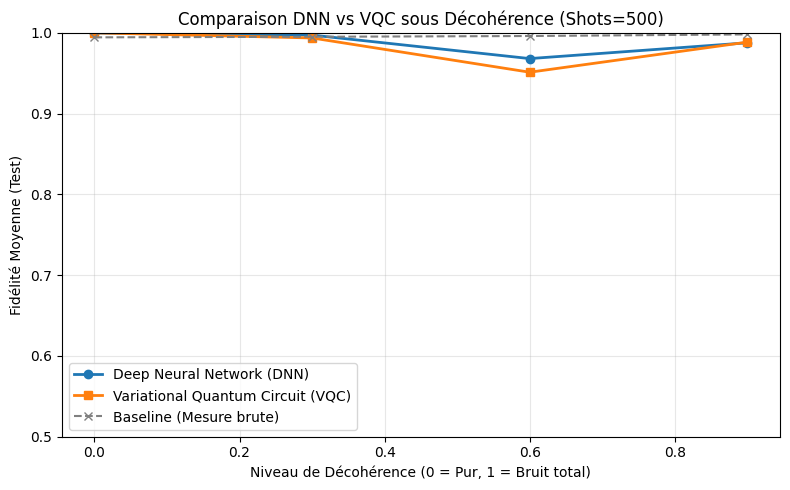

In [ ]:


# 7. PLOT FOR REPORT

plt.figure(figsize=(8, 5))
plt.plot(DECOHERENCE_LEVELS, results['dnn'], '-o', linewidth=2, label='Deep Neural Network (DNN)')
plt.plot(DECOHERENCE_LEVELS, results['vqc'], '-s', linewidth=2, label='Variational Quantum Circuit (VQC)')
plt.plot(DECOHERENCE_LEVELS, results['baseline'], '--x', color='gray', label='Baseline (Mesure brute)')

plt.title(f"Comparaison DNN vs VQC sous Décohérence (Shots={N_SHOTS})")
plt.xlabel('Niveau de Décohérence (0 = Pur, 1 = Bruit total)')
plt.ylabel('Fidélité Moyenne (Test)')
plt.ylim(0.5, 1.0) 
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()